<a href="https://colab.research.google.com/github/syedokun/HAD7001/blob/main/Project/Project_Phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and environment setup

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### Data Processing

In [ ]:
health = pd.read_pickle(r'C:\Users\Syed\Downloads\Research\Care4minds\health.pkl')

In [ ]:
health.columns

Index(['HealthCondition_ID', 'Network_ID', 'Site_ID', 'Patient_ID',
       'Encounter_ID', 'Cycle_ID', 'DiagnosisText_orig', 'DiagnosisText_calc',
       'DiagnosisCodeType_orig', 'DiagnosisCodeType_calc',
       'DiagnosisCode_orig', 'DiagnosisCode_calc', 'DateOfOnset',
       'SignificantNegativeFlag', 'ActiveInactiveFlag', 'DateCreated'],
      dtype='object')

In [ ]:
health.shape

(2571583, 16)

In [ ]:
# Remove all rows with empty values in DiagnosisCode_calc and DiagnosisText_orig
health = health.dropna(subset=['DiagnosisCode_calc'])
health = health.dropna(subset=['DiagnosisText_orig'])

In [ ]:
grouped_diagnoses = pd.read_csv(r"C:\Users\Syed\Downloads\Research\Care4minds\mh_diagnoses_cleaned_grouped.csv")

In [ ]:
# Acccording to the mapping of DiagnosisCode_calc to DSM5_group (ICD9 code to DSM5 group mapping) in grouped_diagnoses_df, create a new column in health df generating the DSM5_group according to the DiagnosisCode_calc

# Create a mapping dictionary from DiagnosisCode_calc to DSM5_group
diagnosis_mapping = dict(zip(grouped_diagnoses['DiagnosisCode_calc'], grouped_diagnoses['DSM5_group']))

health['DSM5_group'] = health['DiagnosisCode_calc'].map(diagnosis_mapping)

print(health[['DiagnosisCode_calc', 'DSM5_group']].head())

  DiagnosisCode_calc                   DSM5_group
0                493  Non Mental Health Disorders
1                414  Non Mental Health Disorders
2              401.9  Non Mental Health Disorders
3              278.0                          NaN
4              706.1  Non Mental Health Disorders


In [ ]:
mental_health_df = health[health['DSM5_group'] != 'Non Mental Health Disorders']

In [ ]:
mental_health_df.shape

(572476, 17)

In [ ]:
# Random sample of 1000 rows from mental_health_df
# mental_health_df = mental_health_df.sample(n=1000, random_state=42)

In [ ]:
mental_health_df = mental_health_df.groupby('DSM5_group', group_keys=False).apply(
    lambda group: group.sample(n=100, random_state=42)
)

In [ ]:
mental_health_df['DSM5_group'].value_counts()

DSM5_group
Anxiety Disorders                                       100
Bipolar and Related Disorders                           100
Depressive Disorders                                    100
Neurocognitive Disorders                                100
Neurodevelopmental Disorders                            100
Personality Disorders                                   100
Schizophrenia Spectrum and Other Psychotic Disorders    100
Sexual Dysfunctions                                     100
Sleep-Wake Disorders                                    100
Substance-Related and Addictive Disorders               100
Trauma- and Stressor-Related Disorders                  100
Name: count, dtype: int64

### Calling the Local LLM

In [ ]:
import pandas as pd
import numpy as np
import warnings
import requests
import json

warnings.filterwarnings('ignore')

def query_local_llm(messages, model="local-llm", context=""):
    """Queries a local LLM server with system and user prompts and context.

    Args:
      messages: A list of dictionaries, where each dictionary represents a message
                with 'role' (system or user) and 'content' keys.
      model: The model name (optional, defaults to "local-llm").
      context:  Additional text to provide context to the LLM.

    Returns:
      The LLM's response as a string, or None if an error occurs.
    """

    url = "http://127.0.0.1:1234/v1/chat/completions"
    headers = {
        "Content-Type": "application/json"
    }

    # Prepend the context to the system message
    if context:
        messages[0]['content'] = context + "\n" + messages[0]['content']

    data = {
        "model": model,
        "messages": messages,
        "max_tokens": 150,
        "temperature": 0.2
    }

    # print("Querying LLM with the following data:")
    # print(json.dumps(data, indent=2))

    try:
        response = requests.post(url, headers=headers, data=json.dumps(data))
        response.raise_for_status()
        response_json = response.json()
        return response_json['choices'][0]['message']['content'].strip()
    except requests.exceptions.RequestException as e:
        print(f"Error querying LLM: {e}")
        return None
    except (KeyError, IndexError) as e:
        print(f"Error parsing LLM response: {e}. Response: {response.text}")
        return None


def read_context_from_file(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return ""


file_path = r"C:\Users\Syed\Downloads\Research\Care4minds\DSM-5.txt"
context = read_context_from_file(file_path)

system_prompt = '''
You are an experienced mental health professional.
Your job is to classify the Diagnosis text given by the user into one of the following 11 categories:
1. Neurodevelopmental Disorders
2. Schizophrenia Spectrum and Other Psychotic Disorders
3. Bipolar and Related Disorder
4. Depressive Disorders
5. Anxiety Disorders
6. Trauma- and Stressor-Related Disorders
7. Sleep-Wake Disorders
8. Sexual Dysfunctions
9. Substance-Related and Addictive Disorders
10. Neurocognitive Disorder
11. Personality Disorders

For Diagnosis text that don't fall under any of these categories and are not related to mental health, categorize as 'Non Mental Health Disorders'.
Only ever output the category name. Nothing before or after it.

## Example:
Input: Depressive episodes leading to suicidal thoughts
Output: Depressive Disorders
'''

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "Depression."}
]

response = query_local_llm(messages, context=context)

if response:
    print(f"LLM Response: {response}")


LLM Response: Depressive Disorders


In [ ]:
file_path = r"C:\Users\Syed\Downloads\Research\Care4minds\DSM-5.txt"
# context = read_context_from_file(file_path)
context = ""

system_prompt = '''
You are an experienced mental health professional.
Your job is to classify the Diagnosis text given by the user into one of the following 11 categories:
1. Neurodevelopmental Disorders
2. Schizophrenia Spectrum and Other Psychotic Disorders
3. Bipolar and Related Disorder
4. Depressive Disorders
5. Anxiety Disorders
6. Trauma- and Stressor-Related Disorders
7. Sleep-Wake Disorders
8. Sexual Dysfunctions
9. Substance-Related and Addictive Disorders
10. Neurocognitive Disorder
11. Personality Disorders

For Diagnosis text that don't fall under any of these categories and are not related to mental health, categorize as 'Non Mental Health Disorders'.
Only ever output the category name. Nothing before or after it.

## Example:
Input: Depressive episodes leading to suicidal thoughts
Output: Depressive Disorders
'''

def calculate_dsm_group(diagnosis_text):
    messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": diagnosis_text}
    ]

    response = query_local_llm(messages, context=context)
    return response

In [ ]:
mental_health_df["DSM_LLM"] = mental_health_df["DiagnosisText_orig"].apply(calculate_dsm_group)

### Cleaning LLM responses

In [ ]:
cleaning_dict = {
    "Neurodevelopmental": "Neurodevelopmental Disorders",
    "Schizophrenia": "Schizophrenia Spectrum and Other Psychotic Disorders",
    "Bipolar": "Bipolar and Related Disorders",
    "Depressive": "Depressive Disorders",
    "Depression": "Depressive Disorders",
    "Anxiety": "Anxiety Disorders",
    "Trauma": "Trauma- and Stressor-Related Disorders",
    "Stress": "Trauma- and Stressor-Related Disorders",
    "Sleep": "Sleep-Wake Disorders",
    "Sexual": "Sexual Dysfunctions",
    "Sex": "Sexual Dysfunctions",
    "Substance": "Substance-Related and Addictive Disorders",
    "Addictive": "Substance-Related and Addictive Disorders",
    "Neurocognitive": "Neurocognitive Disorders",
    "Personality": "Personality Disorders"
    }

In [ ]:
# If the keys in cleaning_dict are a substring match with the values in column 'DSM_LLM', replace the text in 'DSM_LLM' with the corresponding values in cleaning_dict. If none of the keys match, replace with "Others"

def clean_dsm_llm(text):
    for key, value in cleaning_dict.items():
        if key in text:
            return value
    return "Others"

mental_health_df["DSM_LLM"] = mental_health_df["DSM_LLM"].apply(clean_dsm_llm)


In [ ]:
mental_health_df['DSM_LLM'].unique()

array(['Anxiety Disorders', 'Neurocognitive Disorders',
       'Depressive Disorders', 'Neurodevelopmental Disorders', 'Others',
       'Bipolar and Related Disorders',
       'Schizophrenia Spectrum and Other Psychotic Disorders',
       'Substance-Related and Addictive Disorders',
       'Sleep-Wake Disorders', 'Personality Disorders',
       'Trauma- and Stressor-Related Disorders', 'Sexual Dysfunctions'],
      dtype=object)

In [ ]:
mental_health_df['DSM5_group'].unique()

array(['Anxiety Disorders', 'Bipolar and Related Disorders',
       'Depressive Disorders', 'Neurocognitive Disorders',
       'Neurodevelopmental Disorders', 'Personality Disorders',
       'Schizophrenia Spectrum and Other Psychotic Disorders',
       'Sexual Dysfunctions', 'Sleep-Wake Disorders',
       'Substance-Related and Addictive Disorders',
       'Trauma- and Stressor-Related Disorders'], dtype=object)

### Evaluation

In [ ]:
evaluation_dict = {
    0: "Neurodevelopmental Disorders",
    1: "Schizophrenia Spectrum and Other Psychotic Disorders",
    2: "Bipolar and Related Disorders",
    3: "Depressive Disorders",
    4: "Anxiety Disorders",
    5: "Trauma- and Stressor-Related Disorders",
    6: "Sleep-Wake Disorders",
    7: "Sexual Dysfunctions",
    8: "Substance-Related and Addictive Disorders",
    9: "Neurocognitive Disorders",
    10: "Personality Disorders",
    11: "Others"
    }

In [ ]:
# Convert keys to values and values to keys for evaluation_dict

evaluation_dict = {value: key for key, value in evaluation_dict.items()}

In [ ]:
# According to the mapping in evaluation dict, convert all strings in the columns 'DSM5_group' and 'DSM_LLM'

def convert_strings(df, column_name, mapping):
    return df[column_name].map(mapping)


mental_health_df['DSM5_group_encoded'] = convert_strings(mental_health_df, 'DSM5_group', evaluation_dict)
mental_health_df['DSM_LLM_encoded'] = convert_strings(mental_health_df, 'DSM_LLM', evaluation_dict)

Accuracy: 0.7836363636363637
Precision: 0.856489103716742
Recall: 0.7836363636363637
F1 Score: 0.8131249836081827


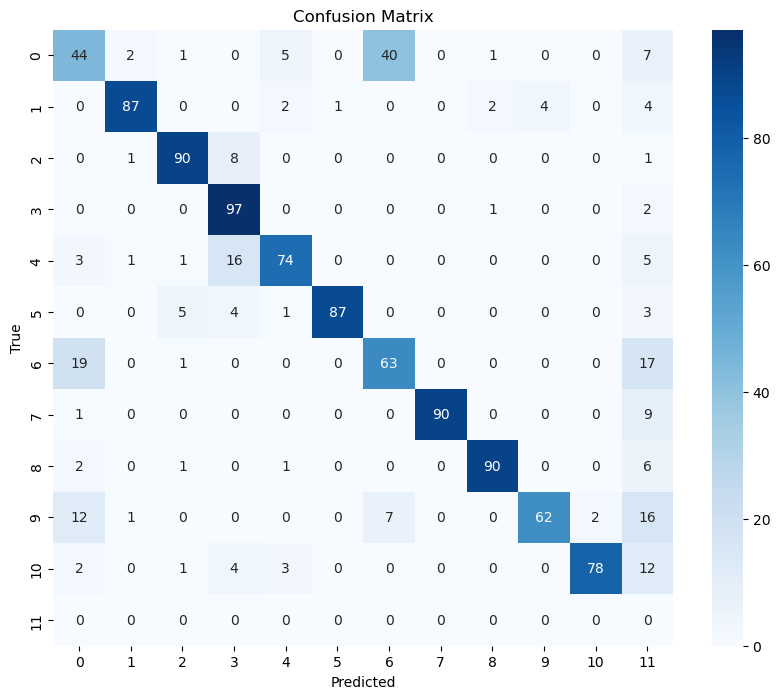

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate evaluation metrics
accuracy = accuracy_score(mental_health_df['DSM5_group_encoded'], mental_health_df['DSM_LLM_encoded'])
precision = precision_score(mental_health_df['DSM5_group_encoded'], mental_health_df['DSM_LLM_encoded'], average='weighted')
recall = recall_score(mental_health_df['DSM5_group_encoded'], mental_health_df['DSM_LLM_encoded'], average='weighted')
f1 = f1_score(mental_health_df['DSM5_group_encoded'], mental_health_df['DSM_LLM_encoded'], average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

unique_labels = list(range(12))

# Confusion Matrix
cm = confusion_matrix(mental_health_df['DSM5_group_encoded'], mental_health_df['DSM_LLM_encoded'], labels=unique_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

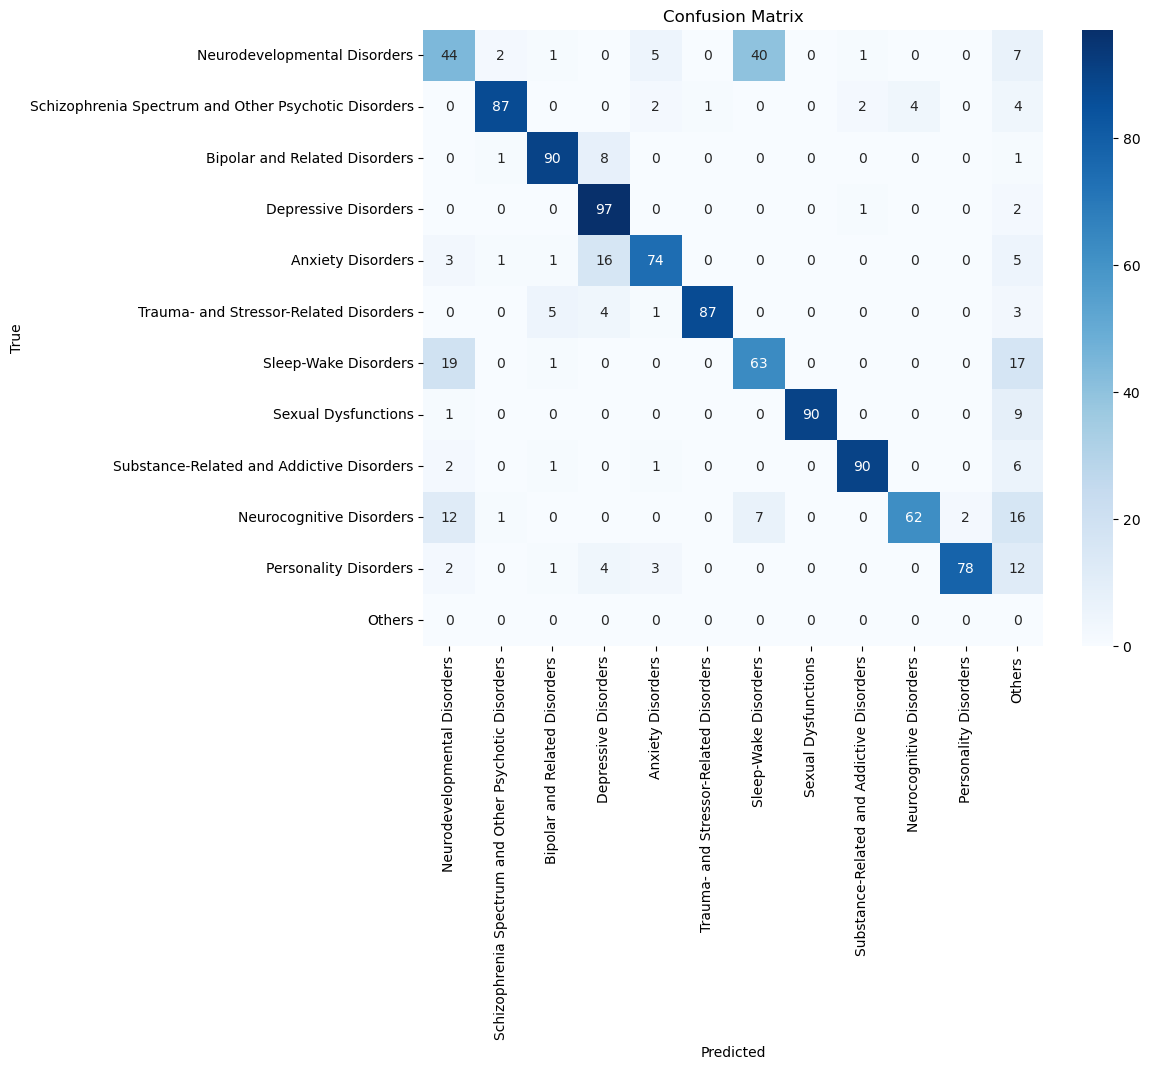

In [ ]:
# Change the labels in the confusion matric from numbers to diagnoses mapped through evaluation_dict

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(mental_health_df['DSM5_group_encoded'], mental_health_df['DSM_LLM_encoded'], labels=unique_labels)

# Create a reversed evaluation_dict for mapping back to labels
reversed_evaluation_dict = {value: key for key, value in evaluation_dict.items()}

# Get the labels from the reversed dictionary
labels = [reversed_evaluation_dict.get(i, str(i)) for i in range(len(evaluation_dict))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Analysis

In [ ]:
# Create a subset of mental_health_df where DSM5_group_encoded and DSM_LLM_encoded do not match
mismatched_df = mental_health_df[mental_health_df['DSM5_group_encoded'] != mental_health_df['DSM_LLM_encoded']]

In [ ]:
mismatched_df.to_csv(r"C:\Users\Syed\Downloads\Research\Care4minds\mismatched_df.csv", index=False)

### Manual Evaluation

Randomly sampled 50 data points to manually evaluate

- -1 = Illegible Diagnosis text
- 0 = Neither is correct
- 1 = ICD9 code is correct
- 2 = LLM is correct
- 3 = Both are correct
- 4 = Ambiguous

In [ ]:
mismatched_df = pd.read_csv(r"C:\Users\Syed\Downloads\Research\Care4minds\mismatched_df.csv")

In [ ]:
mismatched_df['Expert eval'].value_counts()

Expert eval
 2.0    22
-1.0    14
 3.0     8
 0.0     3
 4.0     1
 1.0     1
Name: count, dtype: int64